### In this notebook, we will take our ugly spaghetti code and add abstraction through the use of functions and classes. 

In [1]:
import random
from matplotlib import pyplot as plt
%matplotlib inline

The code below sets the jupyter notebook "pager" to print inline, so that it pager outputs can be viewed on GitHub without running the notebook

In [2]:
def page_printer(data, start=0, screen_lines=0, pager_cmd=None):
    if isinstance(data, dict):
        data = data['text/plain']
    print(data)

import IPython.core.page
IPython.core.page.page = page_printer

Our ECA spaghetti code

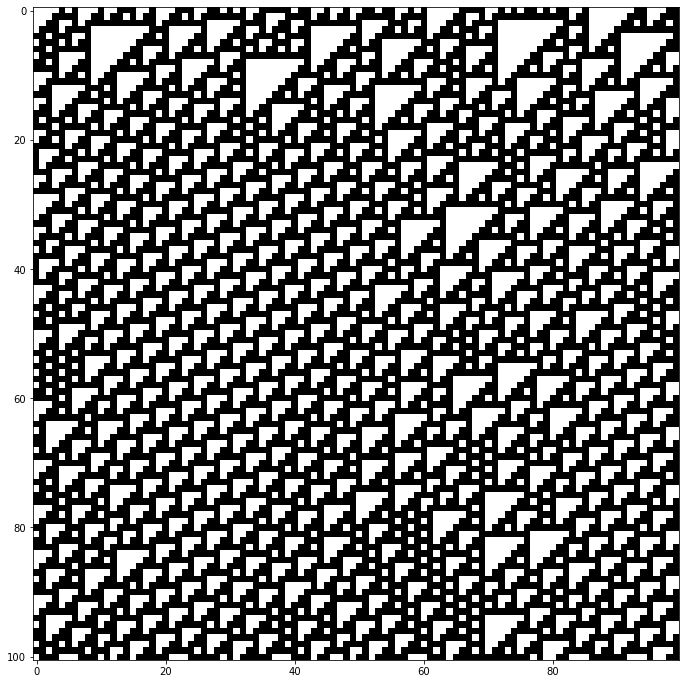

In [3]:
rule_number = 110
length = 100
time = 100 

# make the initial condition
initial_condition = []
for i in range(length):
    initial_condition.append(random.randint(0,1))

# create list of neighborhood tuples in lex. order
neighborhoods = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1)]

# convert the rule number to binary and padd with 0s as needed
in_binary = bin(rule_number)[2:][::-1]
binary_length = len(in_binary)
if binary_length != 8:
    padding = 8 - binary_length
    in_binary = in_binary + '0'*padding

# create the lookup table dictionary
lookup_table = {}
for i in range(8):
    key = neighborhoods[i]
    val = in_binary[i]
    lookup_table.update({key:val})
    
# initialize spacetime field and current configuration
spacetime_field = [initial_condition]
current_configuration = initial_condition.copy()

# apply the lookup table to evolve the CA for the given number of time steps
for t in range(time):
    new_configuration = []
    for i in range(len(current_configuration)):
        
        neighborhood = (current_configuration[(i-1)], 
                        current_configuration[i], 
                        current_configuration[(i+1)%length])
        
        new_configuration.append(int(lookup_table[neighborhood]))
        
    current_configuration = new_configuration
    spacetime_field.append(new_configuration)
    
# plot the spacetime field diagram
plt.figure(figsize=(12,12))
plt.imshow(spacetime_field, cmap=plt.cm.Greys, interpolation='nearest')
plt.show()

As a first demonstration, here is a basic function that produces a random bit string of a given length. 

In [4]:
def random_string_basic(length):
    return [random.randint(0,1) for _ in range(length)]

In [5]:
print(random_string_basic(20))

[1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1]


This function gets the job done. However, it is not good coding practice to make such bare-bones functions. It is always a good idea to add doc strings to your function. This will make it much easier for others to know what your function is supposed to do; including what valid inputs are and what kind of outputs are expected. To take this even further, you can use 'raise' statements to raise an error if your function is given invalid inputs. For instance, if you were to pass a non-integer or negative integer value into our basic random string function, it will return an error (as shown below). For such a simple function it should be clear how these inputs break the function, but in more complicated situations it will not always be so clear. Therefore it is advised to use such assert statements to capture expected disruptions in functionality. 

In [6]:
def random_string(length):
    '''
    Returns a random bit string of the given length. 
    
    Parameters
    ----------
    length: int
        Posivite integer that specifies the desired length of the bit string.
        
    Returns
    -------
    out: list
        The random bit string given as a list, with int elements.
    '''
    if not isinstance(length, int) or length < 0:
        raise ValueError("input length must be a positive ingeter")
    return [random.randint(0,1) for _ in range(length)]

In [7]:
print(random_string(20))

[1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]


docstrings can be accessed using the '?' operator

In [8]:
random_string?

Signature: random_string(length)
Docstring:
Returns a random bit string of the given length. 

Parameters
----------
length: int
    Posivite integer that specifies the desired length of the bit string.
    
Returns
-------
out: list
    The random bit string given as a list, with int elements.
File:      c:\users\adam.000\dropbox\code\scientific-python-tutorials\<ipython-input-6-d462fcde14a9>
Type:      function



In [9]:
print(random_string_basic(1.2))

TypeError: 'float' object cannot be interpreted as an integer

In [10]:
print(random_string(1.2))

ValueError: input length must be a positive ingeter

In the first example, a general TypeError is given that is not directly related to random string function that the user is interfacing with. This can make debugging much more difficult in more complicated situations. The same error is flagged in way that clearly relates to the inputs given by the user when raising our own ValueError, making it much easier to debug. 

It does not make much sense to create the neighborhoods function below. It should just be a global variable. One reason you might do something like this though is if you're prototyping code and this acts as a placeholder for a future function. In this case, we eventually want a general 1D CA simulator, in which case a neighborhoods function would be nontrivial.

In [11]:
def neighborhoods():
    '''
    Returns a list of neighborhood tuples in lexicographical order.
    '''
    return [(0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1)]

In [12]:
print(neighborhoods())

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


We will not actually use this function, and just define a local neighborhoods variable inside the lookup table function below

The function below is one that we certainly will use. It creates the lookup table dictionary for a given rule number.

In [13]:
def lookup_table(rule_number):
    '''
    Returns a dictionary which maps ECA neighborhoods to output values. 
    Uses Wolfram rule number convention.
    
    Parameters
    ----------
    rule_number: int
        Integer value between 0 and 255, inclusive. Specifies the ECA lookup table
        according to the Wolfram numbering scheme.
        
    Returns
    -------
    lookup_table: dict
        Lookup table dictionary that maps neighborhood tuples to their output according to the 
        ECA local evolution rule (i.e. the lookup table), as specified by the rule number. 
    '''
    if not isinstance(rule_number, int) or rule_number < 0 or rule_number > 255:
        raise ValueError("rule_number must be an int between 0 and 255, inclusive")
    neighborhoods = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1)]
    in_binary = '{:{fill}{align}{width}b}'.format(rule_number, 
                                                  fill='0', 
                                                  align='>', 
                                                  width='8')
    
    return dict(zip(neighborhoods, map(int,reversed(in_binary)))) # use map so that outputs are ints, not strings

Notice that we have used 'map' convert all the values of in_binary from str to int. 

A little demo of how map works; it is very similar to list comprehensions: (map is an iterator in Python 3, so I've used list() to conver it to a list for visualization purposes)

In [14]:
print(list(map(int,'{:{fill}{align}{width}b}'.format(90, 
                                                  fill='0', 
                                                  align='>', 
                                                  width='8')
              )
          )
     )
     
print([int(i) for i in '{:{fill}{align}{width}b}'.format(90, 
                                                  fill='0', 
                                                  align='>', 
                                                  width='8')]
     )

[0, 1, 0, 1, 1, 0, 1, 0]
[0, 1, 0, 1, 1, 0, 1, 0]


In [15]:
for key, val in lookup_table(90).items():
    print(key, '-->', val)

(0, 0, 0) --> 0
(0, 0, 1) --> 1
(0, 1, 0) --> 0
(0, 1, 1) --> 1
(1, 0, 0) --> 1
(1, 0, 1) --> 0
(1, 1, 0) --> 1
(1, 1, 1) --> 0


### Testing our lookup table code

When writing our spaghetti code, we never specifically tested whether our implementation of the lookup table was producing the expected behavior. Let's do that now, before moving on. Another benefit of using functions to abstract and generalize our code is that we can also test our code much more thoroughly and efficiently. 

First, we should test the edge cases. Rule '0' should produce all zero outputs and rule '255' should produce all ones. Because we added a raise statement to our function, it will not allow values outside this range, but we should still test that it does this as expected (I caught a mistake I made in my first attempt by testing the edge cases). Finally, let's test a few values inside the valid range. Rule '90' is the XOR of the two outer bits of the neighborhood: if the outer bits are the same the output is zero, if they are different the output is one. Rule '22' outputs a one if there is a single one in the neighborhood and outputs a zero otherwise. Let's now test these different cases

Ideally you should use a testing framework like [nose](https://nose.readthedocs.io/en/latest/), especially if your code will be integrated into a larger project that others will depend on. This level of testing automation is beyond the scope of these tutorials. Here I'll show some basic level of testing to get started. 

Here is a function that tests the lookup table for rule 0. This is similar to the kind of function you would use with the 'nose' framework, but you would not write the `return` statement in nose. 

If the lookup table gives the expected output, no AssertionErrors will be raised and the function will terminate with a message letting us know all outputs are correct. 

In [16]:
print(neighborhoods())

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [17]:
def test_lookup_table0():
    lt = lookup_table(0)
    expected_outputs = [0,0,0,0,0,0,0,0] # outputs in lexicographical order
    for neighborhood, expected_out in zip(neighborhoods(), expected_outputs):
        assert lt[neighborhood] == expected_out,\
        "neighborhood {} gives wrong output!".format(neighborhood)
    print("all outputs look good!") # remove if using testing framework like nose

In [18]:
test_lookup_table0()

all outputs look good!


Just as a demonstration of how this test function would behave if the lookup table is not working as expected, let's copy the same test function, but change one of the bits in the expected outputs (i.e. we will test our lookup_table function for rule 0 against some other rule that is not rule 0. 

In [19]:
def test_lookup_table_fail():
    lt = lookup_table(0)
    expected_outputs = [0,0,0,0,0,0,0,1] # outputs in lexicographical order
    for neighborhood, expected_out in zip(neighborhoods(), expected_outputs):
        assert lt[neighborhood] == expected_out,\
        "neighborhood {} gives wrong output!".format(neighborhood)
    print("all outputs look good!") # remove if using testing framework like nose

In [20]:
test_lookup_table_fail()

AssertionError: neighborhood (1, 1, 1) gives wrong output!

Let's now repeat this and write similar test functions for the other cases we want to test. 

It is good to do thorough testing of your code, and as you can see it starts to get pretty cumbersome. This is why automated testing frameworks like nose are so helpful.

In [21]:
def test_lookup_table255():
    lt = lookup_table(255)
    expected_outputs = [1,1,1,1,1,1,1,1] # outputs in lexicographical order
    for neighborhood, expected_out in zip(neighborhoods(), expected_outputs):
        assert lt[neighborhood] == expected_out,\
        "neighborhood {} gives wrong output!".format(neighborhood)
    print("all outputs look good!") # remove if using testing framework like nose

In [22]:
test_lookup_table255()

all outputs look good!


In [23]:
def test_lookup_table90():
    lt = lookup_table(90)
    expected_outputs = [0,1,0,1,1,0,1,0] # outputs in lexicographical order
    for neighborhood, expected_out in zip(neighborhoods(), expected_outputs):
        assert lt[neighborhood] == expected_out,\
        "neighborhood {} gives wrong output!".format(neighborhood)
    print("all outputs look good!") # remove if using testing framework like nose

In [24]:
test_lookup_table90()

all outputs look good!


In [25]:
def test_lookup_table22():
    lt = lookup_table(22)
    expected_outputs = [0,1,1,0,1,0,0,0] # outputs in lexicographical order
    for neighborhood, expected_out in zip(neighborhoods(), expected_outputs):
        assert lt[neighborhood] == expected_out,\
        "neighborhood {} gives wrong output!".format(neighborhood)
    print("all outputs look good!") # remove if using testing framework like nose

In [26]:
test_lookup_table22()

all outputs look good!


Finally, before moving on let's just try running our lookup table code for values outside the expected range and make sure it raises the ValueError we put in. 

In [27]:
print(lookup_table(-1))

ValueError: rule_number must be an int between 0 and 255, inclusive

In [28]:
print(lookup_table(256))

ValueError: rule_number must be an int between 0 and 255, inclusive

## Spacetime field function

Let's now make a function that produces a spacetime field for a given ECA by using our lookup_table function

Notice that we are doing something different at the beginning of the function to catch invalid inputs for `time_steps`. Rather than strictly enforcing that the input should be a Python `int`, we will allow valid representations of integers using a `try`-`except` clause. For example, the integer 1 can be given as an `int (1)`, a `float (1.0)`, or a `str ('1')`. Note though that if a non-integer float is given, it will be converted to the floor of that value. Whether you want this behavior for your function, or strictly enforce `int` time steps is the kind of design choice that you will have to make with more complex code like this. However, it is still preferable that this kind of choice is made by you (the person writing the code) and not left for default Python behaviors. Well-designed code is easier to use and easier to debug. 

Also note that we don't not need to repeat code for catching invalid inputs for `rule_number` here since the `lookup_table` funciton is called inside `spacetime_field`, so it will still catch invalid inputs once `lookup_table` is called.

In [29]:
def spacetime_field(rule_number, initial_condition, time_steps):
    '''
    Returns a spacetime field array using the given rule number on the 
    given initial condition for the given number of time steps.
    
    Parameters
    ----------
    rule_number: int
        Integer value between 0 and 255, inclusive. Specifies the ECA lookup table
        according to the Wolfram numbering scheme.
    initial_condition: list
        Binary string used as the initial condition for the ECA. Elements of the list
        should be ints. 
    time_steps: int
        Positive integer specifying the number of time steps for evolving the ECA. 
    '''
    if time_steps < 0:
        raise ValueError("time_steps must be a non-negative integer")
    # try converting time_steps to int and raise a custom error if this can't be done
    try:
        time_steps = int(time_steps)
    except ValueError:
        raise ValueError("time_steps must be a non-negative integer")
        
    # we will see a cleaner and more efficient way to do the following when we introduce numpy
    for i in initial_condition:
        if i not in [0,1]:
            raise ValueError("initial condition must be a list of 0s and 1s")
        
    lookup = lookup_table(rule_number)
    length = len(initial_condition)
    
    # initialize spacetime field and current configuration
    spacetime_field = [initial_condition]
    current_configuration = initial_condition.copy()

    # apply the lookup table to evolve the CA for the given number of time steps
    for t in range(time_steps):
        new_configuration = []
        for i in range(length):

            neighborhood = (current_configuration[(i-1)], 
                            current_configuration[i], 
                            current_configuration[(i+1)%length])

            new_configuration.append(lookup[neighborhood])

        current_configuration = new_configuration
        spacetime_field.append(new_configuration)
    
    return spacetime_field

Let's just make sure it runs for some (appropriate) inputs

In [30]:
for config in spacetime_field(18, random_string(20), 20):
    print(config)

[1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
[1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]
[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]
[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
[0, 1, 0, 0, 1, 0, 0, 0,

Here is a simple function for making a spacetime diagram image of our spacetime fields. Testing visualizations is very difficult, so we will not worry about that here. 

For our specific code of simulating elementary cellular automata, visualizing spacetime diagrams provides a quick qualitative test for whether the simulator is working properly. Specifically, we can simulate a 'unit seed' initial condition with a single '1' in the center and all other values '0'. Spacetime diagrams of this initial condition for all 256 ECAs can be found [here](https://mathworld.wolfram.com/ElementaryCellularAutomaton.html) for visual comparison. 

In [31]:
def spacetime_diagram(spacetime_field, size=12, colors=plt.cm.Greys):
    '''
    Produces a simple spacetime diagram image using matplotlib imshow with 'nearest' interpolation.
    
   Parameters
    ---------
    spacetime_field: array-like (2D)
        1+1 dimensional spacetime field, given as a 2D array or list of lists. Time should be dimension 0;
        so that spacetime_field[t] is the spatial configuration at time t. 
        
    size: int, optional (default=12)
        Sets the size of the figure: figsize=(size,size)
    colors: matplotlib colormap, optional (default=plt.cm.Greys)
        See https://matplotlib.org/tutorials/colors/colormaps.html for colormap choices.
        A colormap 'cmap' is called as: colors=plt.cm.cmap
    '''
    plt.figure(figsize=(size,size))
    plt.imshow(spacetime_field, cmap=colors, interpolation='nearest')
    plt.show()

In [32]:
def unit_seed(margin_length):
    '''
    Returns a list of a single '1' bounded by margin_length number of '0's 
    on either side. 
    
    Parameters
    ----------
    margin_length: int
        Number of zeros bounding the central one on either side. 
        
    Returns
    -------
    out: list
        [0,]*margin_length + [1,] + [0,]*margin_length
    '''
    if not isinstance(margin_length, int) or margin_length < 0:
        raise ValueError("margin_length must be a postive int")
    
    return [0,]* margin_length + [1,] + [0,]*margin_length

In [33]:
print(unit_seed(4))

[0, 0, 0, 0, 1, 0, 0, 0, 0]


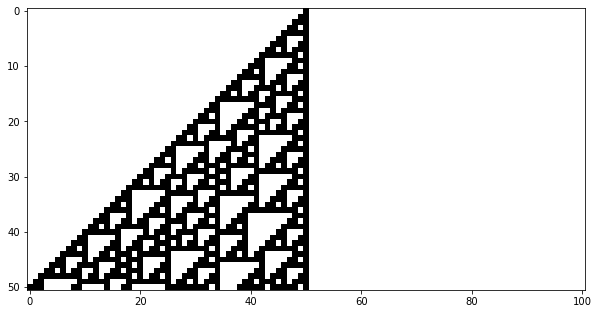

In [34]:
field = spacetime_field(110, unit_seed(50), 50)
spacetime_diagram(field, 10)

This what rule 110 should look like with a unit seed initial condition. 

## Testing spacetime field code

It is good to have a quick visual check that our simulator is doing something reasonable. But of course we want more thorough testing than that. Having test functions, like we made for the lookup_table code, will be particularly useful since we will be making multiple versions of the ECA simulator. Each time we make a new version we can just call our suite of test functions and quickly make sure everything is working properly. 

In the next tutorial we will discuss numpy and see how numpy arrays are ideal for use in our simulator. Here though will just borrow one function from numpy that will make testing spacetime fields much easier: `array_equal`

In [35]:
from numpy import array_equal

In [36]:
print(array_equal([0,1,0,1,1], [0,1,0,1,1]))
print(array_equal([0,1,0,1,1], [0,1,0,1,2]))

True
False


Here is our test strategy. Let's test the same four ECA rules that we tested for `lookup_table`: the two edge case rules 1 and 256, and two 'interior' rules 90 and 22. The edge cases are 'trivial' rules that always produce the same spatial configurations for any initial condition. So it is easy to test these for many time steps. The two interior rules have non-trivial behavior and are harder to test for many time steps. Therefore we will test these for just two time steps, where we will compute the proper output by hand (the local update rule for these are described above with the `lookup_table` test code). We will do this using unit seed initial conditions, but with the single '1' off-center. This will allow us to test that the periodic boundary conditions are working properly. We will check one side with rule 90 and the other with rule 22. 

In [37]:
def test_spacetime0():
    obs_field = spacetime_field(0, random_string(20), 20)
    expected_config = [0,]*20
    
    for time, observed_config in enumerate(obs_field[1:]): # skip the random initial condition
        assert array_equal(observed_config, expected_config), \
        "configuration at time {} not correct".format(time)
    print('All configurations correct!') # remove if using testing framework like nose

In [38]:
test_spacetime0()

All configurations correct!


In [39]:
def test_spacetime255():
    obs_field = spacetime_field(255, random_string(20), 20)
    expected_config = [1,]*20
    
    for time, observed_config in enumerate(obs_field[1:]): # skip the random initial condition
        assert array_equal(observed_config, expected_config), \
        "configuration at time {} not correct".format(time)
    print('All configurations correct!') # remove if using testing framework like nose

In [40]:
test_spacetime255()

All configurations correct!


For our tests of rule 22 and 90, it's easier to first run the expected code and check it by hand. Once we have checked the output by hand, we can put the results into a test function

In [41]:
initial = [0,1,0,0,0,0]
field = spacetime_field(22, initial, 2)
for config in field:
    print(config)

[0, 1, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 1]


Recall that rule 22 updates a site to the value '1' if and only if there is a single '1' in it's neighborhood. So for a unit seed, the three values in the local neighborhood of the seed are updated to '1', as we see above. At the next time step, only the two configurations immediately outside that original neighborhood have a single '1' and are thus updated to '1'. This is what we see, accounting for the periodic boundary condition wrapping on the left.

In [42]:
def test_spacetime22():
    initial = [0,1,0,0,0,0]
    obs_field = spacetime_field(22, initial, 2)
    expected_config_1 = [1, 1, 1, 0, 0, 0]
    expected_config_2 = [0, 0, 0, 1, 0, 1]
    assert array_equal(obs_field[1], expected_config_1), \
    "time step 1 is incorrect"
    assert array_equal(obs_field[2], expected_config_2),\
    "time step 2 is incorrect"
    print('both time steps give correct output') # remove if using testing framework like nose

In [43]:
test_spacetime22()

both time steps give correct output


In [44]:
initial = [0,0,0,0,0,1,0]
field = spacetime_field(90, initial, 2)
for config in field:
    print(config)

[0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 1, 0, 1]
[1, 0, 0, 1, 0, 0, 0]


Recall that rule 90 is the XOR of the outer two bits in the local neighborhood. For the first time steps, the outer two bits in the neighborhood of the unit seed should update to '1', as we see above. At the next time steps there are again two '1's, moving outward as seen above. 

In [45]:
def test_spacetime90():
    initial = [0,0,0,0,0,1,0]
    obs_field = spacetime_field(90, initial, 2)
    expected_config_1 = [0, 0, 0, 0, 1, 0, 1]
    expected_config_2 = [1, 0, 0, 1, 0, 0, 0]
    assert array_equal(obs_field[1], expected_config_1), \
    "time step 1 is incorrect"
    assert array_equal(obs_field[2], expected_config_2),\
    "time step 2 is incorrect"
    print('both time steps give correct output') # remove if using testing framework like nose

In [46]:
test_spacetime90()

both time steps give correct output


# Classes

We now introduces classes as a next level of abstraction. A full discussion of classes and object-oriented design is beyond the scope of these tutorials. I recommend checking out some textbooks or online resources for that. Here I want to give an introduction by example, with the specific context of our ECA simulator. Simulators are particularly well-suited for using classes. 

You may have heard that "everything in Python is an object"; it is therefore useful to know some of the basics of classes even if you don't plan to make your own classes for your project. 

In Python a `class` is like a template for create 'objects'. Objects are particular instances of a class. Here we will create a general ECA `class` that produces simulator objects when a particular rule number is specified. 

Objects are a collection of data (called 'attributes') and functions (called 'methods') that act on the data. 

Below is a simple object-oriented ECA simulator. 

Objects of the ECA class have the lookup table, current configuration, and spacetime field as the main attributes. The initial condition is also stored as an attribute. An additional attribute, length, is stored from initialization and passed to the evolve method, when it is called. Because length is used "internally" in this way, it has an additional underscore in its name, to signal that is meant to be used this way and should not be otherwise modified by the user. 

Note the use of `self` throughout. This refers to instances of the class. Attributes that look like `self.attribute` are called instance variables, because they are specified for each instance of the class. They should be defined within methods, typically in `__init__`. For methods, self is always the first argument and it specifies that the methods act on particular instances. For example, if you have a class with a method, called `method_1()` and want to use that method inside of another method called `method_2()`, you would write it as `self.method_1()`. 

In [47]:
class ECA(object):
    '''
    Elementary cellular automata simulator.
    '''
    def __init__(self, rule_number, initial_condition):
        '''
        Initializes the simulator for the given rule number and initial condition.
        
        Parameters
        ----------
        rule_number: int
            Integer value between 0 and 255, inclusive. Specifies the ECA lookup table
            according to the Wolfram numbering scheme.
        initial_condition: list
            Binary string used as the initial condition for the ECA. Elements of the list
            should be ints. 
        
        Attributes
        ----------
        lookup_table: dict
            Lookup table for the ECA given as a dictionary, with neighborhood tuple keys. 
        initial: array_like
            Copy of the initial conditions used to instantiate the simulator
        spacetime: array_like
            2D array (list of lists) of the spacetime field created by the simulator.
        current_configuration: array_like
            List of the spatial configuration of the ECA at the current time
        '''
        # we will see a cleaner and more efficient way to do the following when we introduce numpy
        for i in initial_condition:
            if i not in [0,1]:
                raise ValueError("initial condition must be a list of 0s and 1s")
                
        self.lookup_table = lookup_table(rule_number)
        self.initial = initial_condition
        self.spacetime = [initial_condition]
        self.current_configuration = initial_condition.copy()
        self._length = len(initial_condition)

    def evolve(self, time_steps):
        '''
        Evolves the current configuration of the ECA for the given number of time steps.
        
        Parameters
        ----------
        time_steps: int
            Positive integer specifying the number of time steps for evolving the ECA.  
        '''
        if time_steps < 0:
            raise ValueError("time_steps must be a non-negative integer")
        # try converting time_steps to int and raise a custom error if this can't be done
        try:
            time_steps = int(time_steps)
        except ValueError:
            raise ValueError("time_steps must be a non-negative integer")

        for _ in range(time_steps): # use underscore if the index will not be used
            new_configuration = []
            for i in range(self._length):

                neighborhood = (self.current_configuration[(i-1)], 
                                self.current_configuration[i], 
                                self.current_configuration[(i+1)%self._length])

                new_configuration.append(self.lookup_table[neighborhood])

            self.current_configuration = new_configuration
            self.spacetime.append(new_configuration)

Before we close this tutorial with some thoughts on how to best use classes and functions in scientific code design, let's modify our tests of the spacetime field function to test this simulator class. 

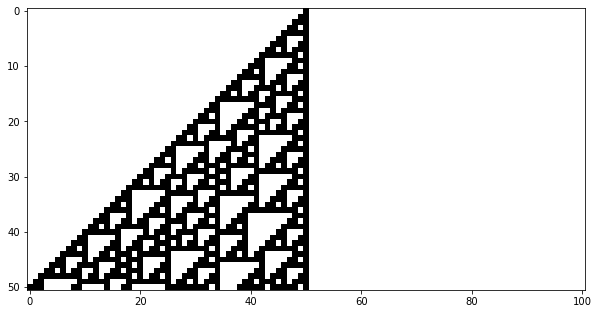

In [48]:
rule_110 = ECA(110, unit_seed(50))
rule_110.evolve(50)
spacetime_diagram(rule_110.spacetime, 10)

In [49]:
def test_simulator0():
    ca = ECA(0, random_string(20))
    ca.evolve(20)
    obs_field = ca.spacetime
    expected_config = [0,]*20
    
    for time, observed_config in enumerate(obs_field[1:]): # skip the random initial condition
        assert array_equal(observed_config, expected_config), \
        "configuration at time {} not correct".format(time)
    print('All configurations correct!') # remove if using testing framework like nose

In [50]:
test_simulator0()

All configurations correct!


In [51]:
def test_simulator255():
    ca = ECA(255, random_string(20))
    ca.evolve(20)
    obs_field = ca.spacetime
    expected_config = [1,]*20
    
    for time, observed_config in enumerate(obs_field[1:]): # skip the random initial condition
        assert array_equal(observed_config, expected_config), \
        "configuration at time {} not correct".format(time)
    print('All configurations correct!') # remove if using testing framework like nose

In [52]:
test_simulator255()

All configurations correct!


In [53]:
def test_simulator22():
    initial = [0,1,0,0,0,0]
    ca = ECA(22, initial)
    ca.evolve(2)
    obs_field = ca.spacetime
    expected_config_1 = [1, 1, 1, 0, 0, 0]
    expected_config_2 = [0, 0, 0, 1, 0, 1]
    assert array_equal(obs_field[1], expected_config_1), \
    "time step 1 is incorrect"
    assert array_equal(obs_field[2], expected_config_2),\
    "time step 2 is incorrect"
    print('both time steps give correct output') # remove if using testing framework like nose

In [54]:
test_simulator22()

both time steps give correct output


In [55]:
def test_simulator90():
    initial = [0,0,0,0,0,1,0]
    ca = ECA(90, initial)
    ca.evolve(2)
    obs_field = ca.spacetime
    expected_config_1 = [0, 0, 0, 0, 1, 0, 1]
    expected_config_2 = [1, 0, 0, 1, 0, 0, 0]
    assert array_equal(obs_field[1], expected_config_1), \
    "time step 1 is incorrect"
    assert array_equal(obs_field[2], expected_config_2),\
    "time step 2 is incorrect"
    print('both time steps give correct output') # remove if using testing framework like nose

In [56]:
test_simulator90()

both time steps give correct output


The main product we want from an ECA simulator is to produce spacetime fields, and our `spacetime_field` function and `ECA` class both do this. Is there a reason then to prefer one over the other? A general rule of thumb is that if you have a class with only one method that is not `__init__`, that code should be done using a function instead. Using classes when you don't need to makes code overly complicated and goes against the zen of Python (see the end of the first tutorial). According to that rule, there is no need to use the `ECA` class we just made if we are just interested in producing spacetime fields. Notice in our tests that it takes more lines of code using the class than the function, and the ECA object is only used to run the evolve method then not used again. 

There may be other features you want from a CA simulator however, like restarting from a different initial condition, rewinding, or evolving the spatial configuration without saving the full history of evolution as a spacetime field. A class would be appropriate to use to put all these features together. There are plenty of other situations where using classes is the best way to go, and the basics shown here can get you started. For example, in a data analytics pipleine you may have some data that you do subsequent manipulations on. If you find yourself passing outputs of one function as arguments into another function, then you should probably use a class instead. 

"Object-oriented design" is a bit of a buzz word, and it can be tempting to overuse classes. Below is a particularly "bad" example of using classes for an ECA simulator, based off an example in this video https://youtu.be/o9pEzgHorH0?t=1043

This uses the intuition of a cell (site), a lattice of cells, and a spacetime field of lattices as being objects, and thus represented as classes. 

In [57]:
class Site(object):
    
    def __init__(self, position, value): 
        self.position = position
        self.value = value
        
    def neighbors(self, length):
        yield self.position-1
        yield self.position
        yield (self.position+1)%length

In [58]:
class Lattice(object):
    
    def __init__(self, length):
        self.length = length
        self.lattice = []
        for i in range(length):
            site_value = random.randint(0,1)
            self.lattice.append(Site(i, site_value))
            
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError
        return self.lattice[index]
    
    def update(self, rule_number):
        self.lookup_table = lookup_table(rule_number)
        updated_lattice = self.lattice[:]
        for site in self:
            neighborhood = ()
            for neighbor_index in site.neighbors(self.length):
                neighborhood += (self.lattice[neighbor_index].value, )
            updated_lattice[site.position] = Site(site.position, 
                                                  int(self.lookup_table[neighborhood]))
        
        self.lattice = updated_lattice

Some notes:

The above is something I threw together pretty quickly and is just meant to demonstrate some things about classes. It is not good code; the ''update'' method of Lattice is not written very efficiently and the ''neighbors'' method of Site should not need the length parameter (a try-except statement when neighbors is called could be used to catch the inex error, as a way to get rid of that parameter).

In the lattice class, having the \__len\__ and \__getitem\__ methods makes lattices iterable, so that something like ''for site in self:'' can be used. 

I don't feel like writing it up, but the natural extension of this would be to then add a SpacetimeField class. It could be made iterable where it iterates through its Lattice objects, the way Lattice objects iterate through Site objects. If you do this it would make sense to have the ''update'' method with the SpacetimeField class and not the Lattice class. But then why have a Lattice class at all? Very quickly you see making these three classes is not the right way to go. In fact, using an array or list of lists for spacetime fields, as we have done up to this point, allows for iteration in exactly the same way that we designed the above classes to be. 

That is, if we have a spacetime field array / list of lists, we can iterate through all points in the field with the following for loops:
       

In [59]:
field = spacetime_field(18, random_string(5), time_steps=3)

print(field, '\n')

for lattice in field:
    print(lattice)
print('\n')

for lattice in field:
    for site in lattice:
        print(site)

[[1, 0, 1, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]] 

[1, 0, 1, 0, 1]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]


1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
